In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from optimization import GDClassifier, SGDClassifier
from oracles import BinaryLogistic
from scipy import sparse
from utils import grad_finite_diff
from scipy import special
from tqdm import tqdm


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%reload_ext autoreload

# 0 Проверка работы алгоритма

In [617]:
np.random.seed(10)
clf1 = GDClassifier(loss_function='binary_logistic')
clf2 = SGDClassifier(loss_function='binary_logistic', batch_size=64)
l, d = 1000, 2
X_train1 = 2*np.random.random((l, d))

y_train1 = np.random.randint(0, 2, l) * 2 - 1
w = np.random.random(d)+2
history1 = clf1.fit(X_train1, y_train1, trace=True, w_0 = w)
history2 = clf2.fit(X_train1, y_train1, trace=True, w_0 = w, log_freq=0.001)


In [618]:
def f(X, y, w):
    """
    :param x: np.array(np.float) вектор длины 2
    :return: np.float
    """
    pred = X @ w
    zero = np.zeros(len(pred))
    return (np.mean(np.logaddexp(zero, -y*pred))
                + 1/2 * np.dot(w[1:], w[1:]))

In [619]:
#Сначала реализуем функцию, вычисляющую градиент

def grad_f(X, y, w):
    """
    Градиент функциии f, определенной выше.
    :param x: np.array[2]: float вектор длины 2
    :return: np.array[2]: float вектор длины 2
    """
    pred = X @ w
    w[0] = 0
    return -np.mean((X.T * y * special.expit(y*pred)*np.exp(-y*pred)).T, axis=0) + 1*w

In [620]:
def draw_3D(func, X_data, y_data, history, ax, name):
    w1 = []
    w2 = []
    for w in history['weights']:
        w1.append(w[0])
        w2.append(w[1])
    
    path = []
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
        
    zs = np.array([func(X_data, y_data, np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)
    
    
    ax.set_title(name)
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    ax.set_zlabel('loss', rotation=90)
    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)
    
    ax.plot(xs=w1, ys=w2, zs=history['func'],
            marker='*', markersize=20, zorder=3,
            markerfacecolor='y', lw=3, c='black')
    
    ax.set_zlim(0, 6)
    ax.view_init(elev=60, roll=-30)
    plt.savefig('charts/test2.pdf')


In [615]:
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=12)

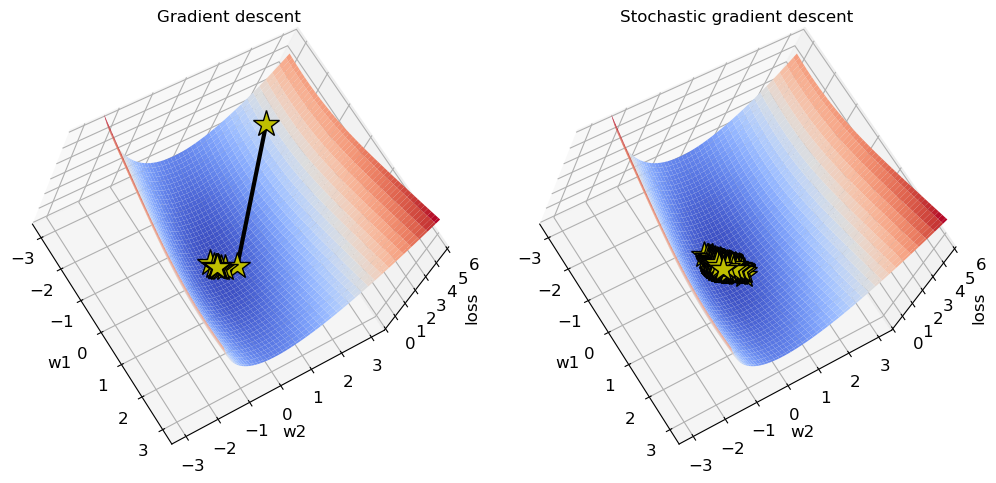

In [621]:
figure, axis = plt.subplots(1, 2, subplot_kw=dict(projection='3d'), figsize = (12, 6))


draw_3D(f, X_train1, y_train1, history1, axis[0], 'Gradient descent')
draw_3D(f, X_train1, y_train1, history2, axis[1], 'Stochastic gradient descent')

In [622]:
np.random.seed(10)
clf1 = GDClassifier(loss_function='binary_logistic', step_alpha=0.1,
                   step_beta=0.5)
clf2 = SGDClassifier(loss_function='binary_logistic', step_alpha=0.1,
                   step_beta=0.5, batch_size=64)


history1 = clf1.fit(X_train1, y_train1, w, trace=True)
history2 = clf2.fit(X_train1, y_train1, w, trace=True, log_freq=0.001)


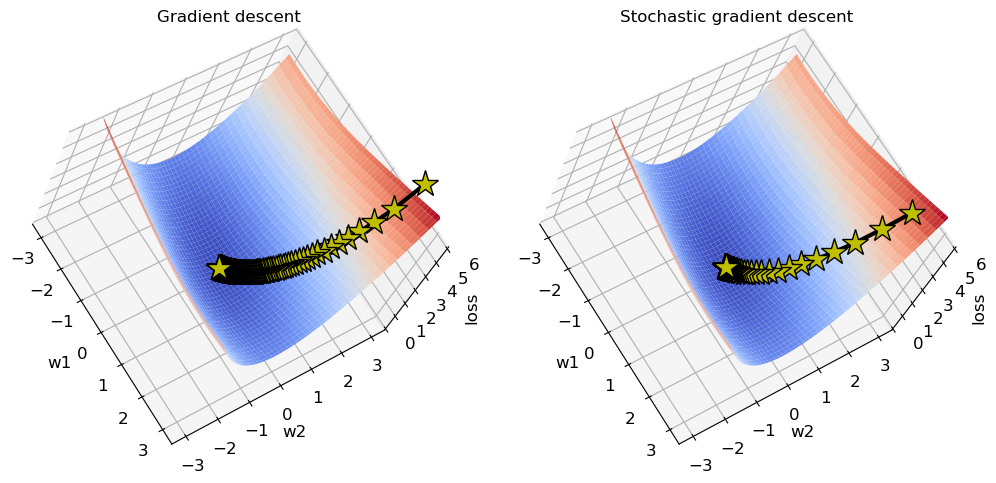

In [623]:
figure, axis = plt.subplots(1, 2, subplot_kw=dict(projection='3d'), figsize = (12, 6))

draw_3D(f, X_train, y_train, history1, axis[0], 'Gradient descent')
draw_3D(f, X_train, y_train, history2, axis[1], 'Stochastic gradient descent')

# 1. Загрузка данных и предобработка данных

In [625]:
data = pd.read_csv('toxic_train.csv')
y_train = data.iloc[:,-1]*2-1
X_train = data.drop('is_toxic', axis=1)

In [626]:
data = pd.read_csv('toxic_test.csv')
y_test = data.iloc[:,-1]*2-1
X_test = data.drop('is_toxic', axis=1)

In [633]:
y_train[4:7]

4   -1
5   -1
6    1
Name: is_toxic, dtype: int64

In [634]:
X_train.iloc[4:7]['comment_text'].to_numpy()


array(["You, sir, are my hero. Any chance you remember what page that's on?",
       '"\n\nCongratulations from me as well, use the tools well. \xa0· talk "',
       'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'], dtype=object)

In [635]:
def only_letters(s):
    s = re.sub('[^a-zA-Z0-9]+', ' ', s)
    s = re.sub(' +', ' ', s)
    return s


X_train['comment_text'] = X_train['comment_text'].apply(only_letters).str.lower().str.strip()
X_test['comment_text'] = X_test['comment_text'].apply(only_letters).str.lower().str.strip()

In [636]:
X_train.iloc[4:7]['comment_text'].to_numpy()


array(['you sir are my hero any chance you remember what page that s on',
       'congratulations from me as well use the tools well talk',
       'cocksucker before you piss around on my work'], dtype=object)

# 2 Векторизация текстов

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
vectorizer = CountVectorizer(lowercase=False, min_df = 0.01)
X_train_vectorized = vectorizer.fit_transform(X_train['comment_text'])
X_test_vectorized = vectorizer.transform(X_test['comment_text']).toarray()
#X_train_vectorized = sparse.csr_matrix(vectorizer.fit_transform(X_train['comment_text']).toarray())
#X_test_vectorized = sparse.csr_matrix(vectorizer.transform(X_test['comment_text']).toarray())

In [17]:
X_train_vectorized

<52061x568 sparse matrix of type '<class 'numpy.int64'>'
	with 1319021 stored elements in Compressed Sparse Row format>

In [18]:
X_test_vectorized

array([[0, 0, 0, ..., 2, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 3, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 3, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# 3 Сравнение методов подсчета градиентов

In [19]:
oracle = BinaryLogistic(1)

In [877]:
%%time
w = np.ones(X_train_vectorized.shape[1])
g1 = grad_finite_diff(oracle.func, X_train_vectorized, y_train, w)[-2:]

100%|██████████████████████████████████| 568/568 [00:05<00:00, 98.87it/s]

CPU times: user 4.82 s, sys: 844 ms, total: 5.66 s
Wall time: 5.75 s


In [883]:
%%timeit
w = np.ones(X_train_vectorized.shape[1])
g2 = oracle.grad(X_train_vectorized, y_train.to_numpy(), w)[-2:]

24.6 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [880]:
print((np.sum((g1-g2)**2))**(0.5))

0.0002930062169214796


5.9s против 39.6s

## Исследование градиентного спуска от параметров

In [22]:
alphas = np.logspace(-5,-1, 5)
betas = np.linspace(0.5, 1, 6)
print(alphas, betas)

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01] [0.5 0.6 0.7 0.8 0.9 1. ]


In [23]:
hist_alpha_beta = {}
for alpha in (alphas):
    print(alpha)
    hist_alpha_beta[alpha] = {}
    for beta in (betas):
        print(beta, end=' ')
        hist = (GDClassifier('binary_logistic', step_alpha=alpha, step_beta=beta, max_iter = 1000)
                        .fit(X_train_vectorized, y_train, trace=True, consider_tolerance = False))
        loss = np.array(hist['func'])
        times = np.arange(len(loss))
        hist_alpha_beta[alpha][beta] = np.hstack((times.reshape(-1,1),loss.reshape(-1,1)))

1e-05
0.5 0.6 0.7 0.8 0.9 1.0 0.0001
0.5 0.6 0.7 0.8 0.9 1.0 0.001
0.5 0.6 0.7 0.8 0.9 1.0 0.01
0.5 0.6 0.7 0.8 0.9 1.0 0.1
0.5 0.6 0.7 0.8 0.9 1.0 

In [24]:
alpha_beta_dfs = []
for alpha in alphas:
    dfs = []
    for beta in betas:
        times = hist_alpha_beta[alpha][beta][:,0]
        loss = hist_alpha_beta[alpha][beta][:,1]
        df = pd.DataFrame()
        df['loss'] = loss
        df['iterration'] = times
        df['beta'] = beta
        
        dfs.append(df)
        
    alpha_beta_dfs.append(pd.concat(dfs, axis=0).reset_index().drop('index', axis=1))

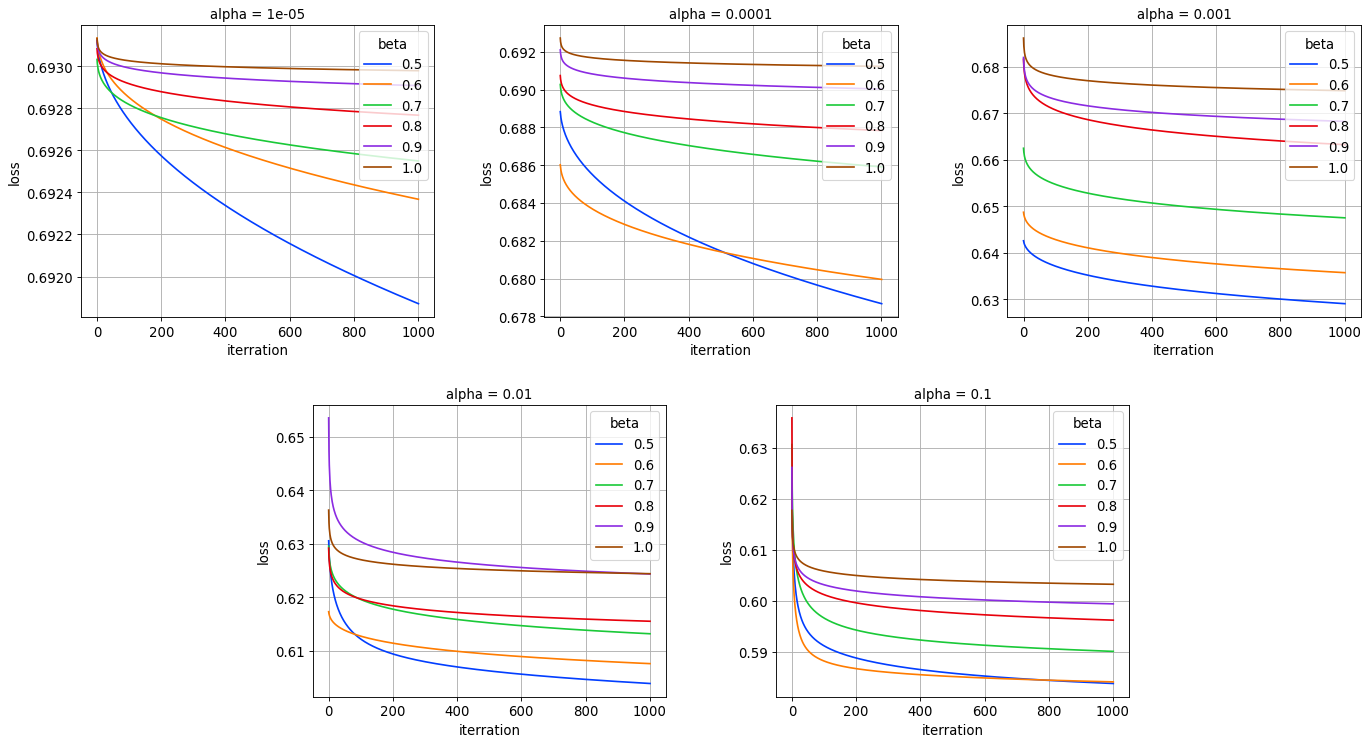

In [665]:
axis = []
plt.figure(figsize=(20, 12), dpi=80)
axis.append(plt.subplot2grid((2, 6), (0, 0), colspan=2))
axis.append(plt.subplot2grid((2, 6), (0, 2), colspan=2))
axis.append(plt.subplot2grid((2, 6), (0, 4), colspan=2)) 
axis.append(plt.subplot2grid((2, 6), (1, 1), colspan=2)) 
axis.append(plt.subplot2grid((2, 6), (1, 3), colspan=2)) 

plt.subplots_adjust(left=0.1,
                            bottom=0.1,
                            right=0.9,
                            top=0.8,
                            wspace=0.9,
                            hspace=0.3)
matplotlib.rcParams["legend.loc"] = 'upper right'

for i in range(len(alpha_beta_dfs)):
    ax = axis[i]
    grid = sns.lineplot(data = alpha_beta_dfs[i], x = 'iterration', y = 'loss', hue = 'beta',  
                    palette='bright', ax=ax)
    ax.set_title('alpha = ' + str(alphas[i]))
    ax.grid(True)
    
plt.savefig('charts/GD_alpha_beta.pdf')
plt.show()

In [27]:
hist_alpha_beta1 = {}
for alpha in (alphas):
    print(alpha)
    hist_alpha_beta1[alpha] = {}
    for beta in (betas):
        print(beta, end=' ')
        hist = (GDClassifier('binary_logistic', step_alpha=alpha, step_beta=beta, max_iter = 1000)
                        .fit(X_train_vectorized, y_train, trace=True, consider_tolerance = False))
        acc = np.array(hist['accuracy'])
        times = np.arange(len(acc))
        hist_alpha_beta1[alpha][beta] = np.hstack((times.reshape(-1,1),acc.reshape(-1,1)))
    print()

1e-05
0.5 0.6 0.7 0.8 0.9 1.0 
0.0001
0.5 0.6 0.7 0.8 0.9 1.0 
0.001
0.5 0.6 0.7 0.8 0.9 1.0 
0.01
0.5 0.6 0.7 0.8 0.9 1.0 
0.1
0.5 0.6 0.7 0.8 0.9 1.0 


In [28]:
alpha_beta_dfs1 = []
for alpha in alphas:
    dfs = []
    for beta in betas:
        times = hist_alpha_beta1[alpha][beta][:,0]
        acc = hist_alpha_beta1[alpha][beta][:,1]
        df = pd.DataFrame()
        df['accuracy'] = acc
        df['iterration'] = times
        df['beta'] = beta
        
        dfs.append(df)
        
    alpha_beta_dfs1.append(pd.concat(dfs, axis=0).reset_index().drop('index', axis=1))

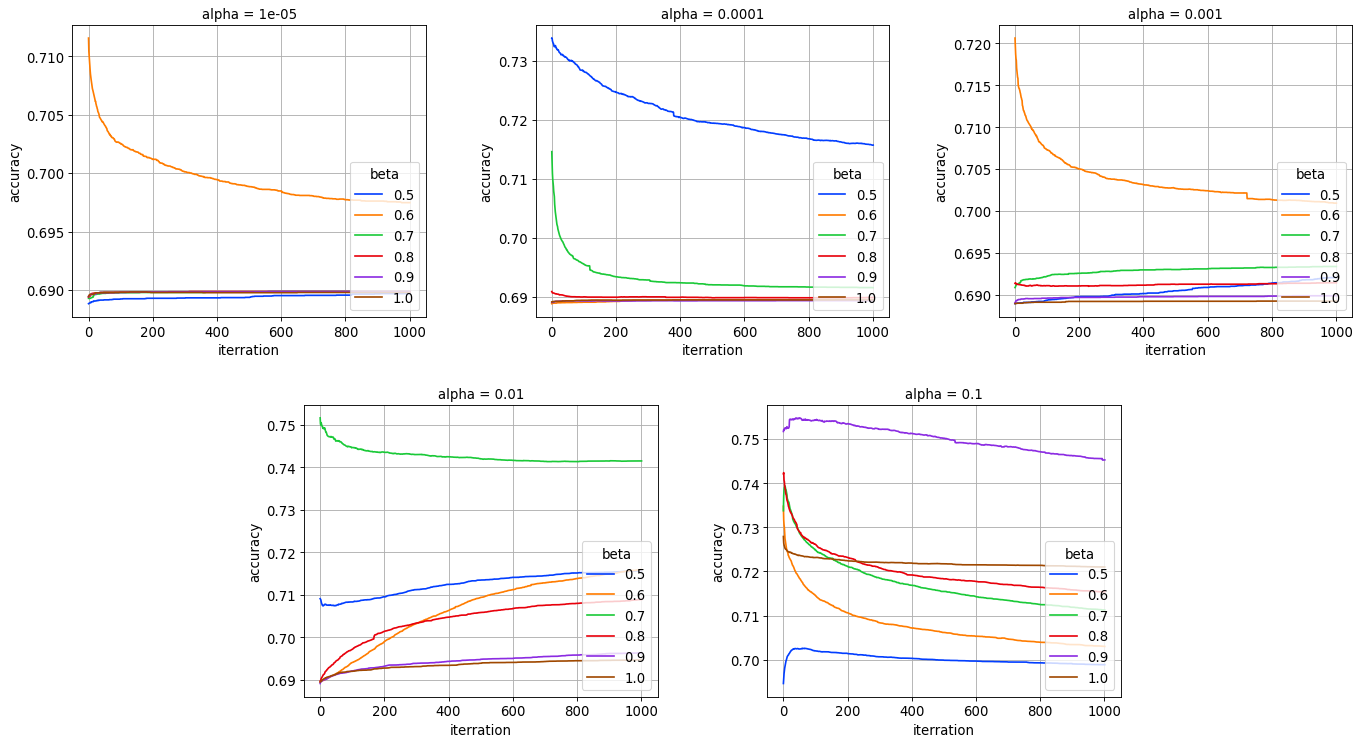

In [668]:
axis = []
plt.figure(figsize=(20, 12), dpi=80)
axis.append(plt.subplot2grid((2, 6), (0, 0), colspan=2))
axis.append(plt.subplot2grid((2, 6), (0, 2), colspan=2))
axis.append(plt.subplot2grid((2, 6), (0, 4), colspan=2)) 
axis.append(plt.subplot2grid((2, 6), (1, 1), colspan=2)) 
axis.append(plt.subplot2grid((2, 6), (1, 3), colspan=2)) 

plt.subplots_adjust(left=0.1,
                            bottom=0.1,
                            right=0.9,
                            top=0.8,
                            wspace=0.9,
                            hspace=0.3)
matplotlib.rcParams["legend.loc"] = 'lower right'

for i in range(len(alpha_beta_dfs)):
    ax = axis[i]
    grid = sns.lineplot(data = alpha_beta_dfs1[i], x = 'iterration', y = 'accuracy', hue = 'beta',  
                    palette='bright', ax=ax)
    ax.set_title('alpha = ' + str(alphas[i]))
    ax.grid(True)

plt.savefig('charts/GD_alpha_beta1.pdf')


plt.show()

Итого лучшие параметры: \
alpha = 0.1 \
beta = 0.6

In [669]:
best_alpha = 0.1
best_beta = 0.6

In [670]:
np.random.seed(777)
weights = []
w0 = np.zeros(X_train_vectorized.shape[1]+1)
w1= np.random.normal(0, 1, X_train_vectorized.shape[1]+1)
w2 = np.random.uniform(-1, 1, X_train_vectorized.shape[1]+1)
w3 = np.zeros(X_train_vectorized.shape[1]+1)
for i in range(X_train_vectorized.shape[1]):
    w3[i+1] = (np.dot(X_train_vectorized[:,i].A.T, y_train) / np.dot(y_train, y_train))[0]
weights.extend([w0, w1, w2, w3, None])

In [671]:
hist_weights = []
for w_0 in tqdm(weights):
    loss = []
    times = []
    if not w_0 is None:
        hist = (GDClassifier('binary_logistic', step_alpha=best_alpha, step_beta=best_beta, max_iter = 400)
                .fit(X_train_vectorized, y_train, w_0=w_0[1:], b = w_0[0], trace=True))
    else:
        hist = (GDClassifier('binary_logistic', step_alpha=best_alpha, step_beta=best_beta, max_iter = 400)
        .fit(X_train_vectorized, y_train, trace=True))
    loss = np.array(hist['func'])
    times = np.arange(len(loss))
    hist_weights.append(np.hstack((times.reshape(-1,1),loss.reshape(-1,1))))

100%|██████████████████████████████████████| 5/5 [03:26<00:00, 41.20s/it]


In [673]:
weights_dfs = []
names = ['$zeros$','$Normal(0,1)$', '$Uniform(-1,1)$' ,'$scalar$ $product$', '$default$']
for i in range(len(names)):
    times = hist_weights[i][:,0]
    loss = hist_weights[i][:,1]
    df = pd.DataFrame()
    df['loss'] = loss
    df['iterration'] = times
    df['Initial approximation'] = names[i]
    weights_dfs.append(df)


weights_df = pd.concat(weights_dfs, axis=0).reset_index().drop('index', axis=1)

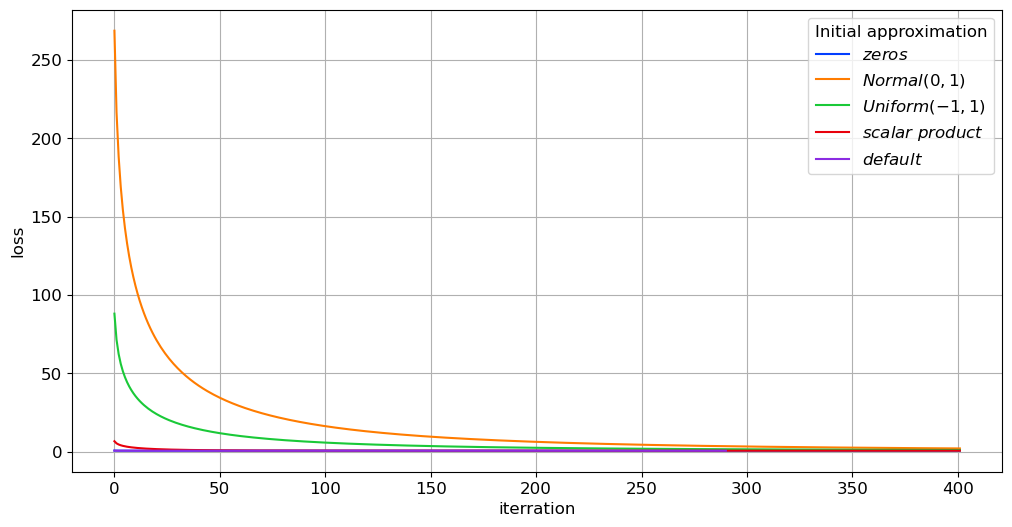

In [674]:
figure, axis = plt.subplots(1, 1, figsize=(12, 6))
matplotlib.rcParams["legend.loc"] = 'upper right'

grid = sns.lineplot(data = weights_df, x = 'iterration', y = 'loss', hue = 'Initial approximation',  
                    palette='bright', ax=axis)

axis.grid(True)

plt.show()

In [675]:
hist_weights1 = []
for w_0 in tqdm(weights):
    loss = []
    times = []
    if not w_0 is None:
        hist = (GDClassifier('binary_logistic', step_alpha=best_alpha, step_beta=best_beta, max_iter = 400)
                .fit(X_train_vectorized, y_train, w_0=w_0[1:], b = w_0[0], trace=True))
    else:
        hist = (GDClassifier('binary_logistic', step_alpha=best_alpha, step_beta=best_beta, max_iter = 400)
        .fit(X_train_vectorized, y_train, trace=True))
    acc = np.array(hist['accuracy'])
    times = np.arange(len(acc))
    hist_weights1.append(np.hstack((times.reshape(-1,1),acc.reshape(-1,1))))

100%|██████████████████████████████████████| 5/5 [03:30<00:00, 42.08s/it]


In [676]:
weights_dfs1 = []
names = ['$zeros$','$Normal(0,1)$', '$Uniform(-1,1)$' ,'$scalar$ $product$', '$default$']
for i in range(len(names)):
    times = hist_weights1[i][:,0]
    acc = hist_weights1[i][:,1]
    df = pd.DataFrame()
    df['accuracy'] = acc
    df['iterration'] = times
    df['Initial approximation'] = names[i]
    weights_dfs1.append(df)


weights_df1 = pd.concat(weights_dfs1, axis=0).reset_index().drop('index', axis=1)

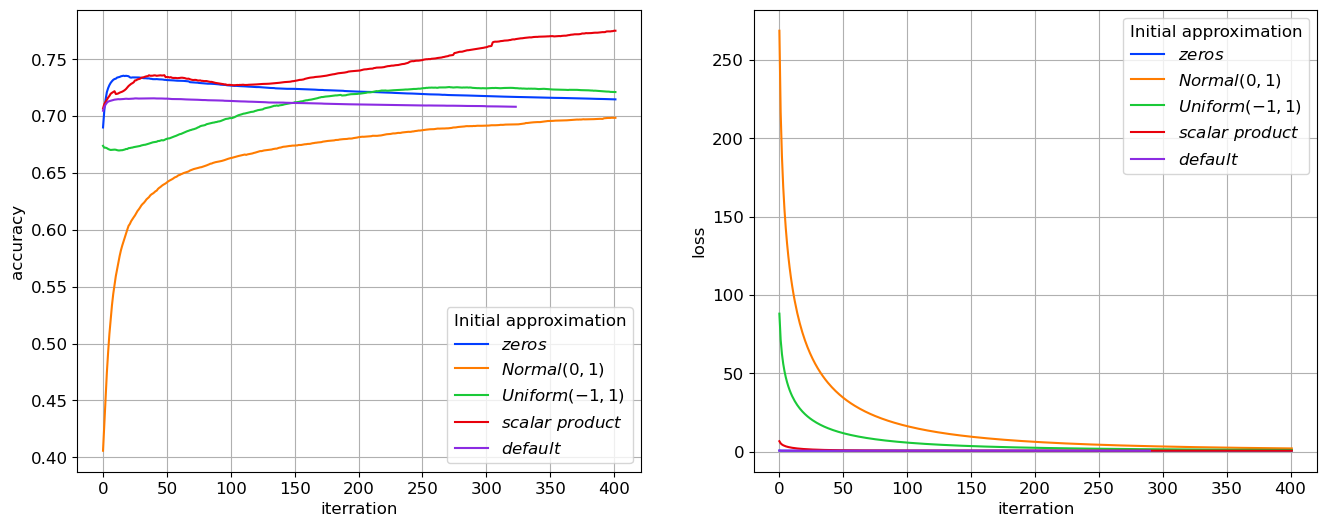

In [686]:
figure, axis = plt.subplots(1, 2, figsize=(16, 6))
matplotlib.rcParams["legend.loc"] = 'lower right'

grid = sns.lineplot(data = weights_df1, x = 'iterration', y = 'accuracy', hue = 'Initial approximation',  
                    palette='bright', ax=axis[0])

axis[0].grid(True)
matplotlib.rcParams["legend.loc"] = 'upper right'

grid = sns.lineplot(data = weights_df, x = 'iterration', y = 'loss', hue = 'Initial approximation',  
                    palette='bright', ax=axis[1])

axis[1].grid(True)
plt.savefig('charts/GD_w0.pdf')

plt.show()

In [39]:
sgd_hist_alpha_beta = {}
for alpha in (alphas):
    print(alpha)
    sgd_hist_alpha_beta[alpha] = {}
    for beta in (betas):
        print(beta, end = ' ')
        hist = (SGDClassifier('binary_logistic', step_alpha=alpha, step_beta=beta, max_iter = 100, batch_size=128)
                        .fit(X_train_vectorized, y_train.to_numpy(), trace=True, consider_tolerance = False, log_freq=0.1, teach_bias=True))
        loss = np.array(hist['func'])
        times = np.array(hist['epoch_num'])
        sgd_hist_alpha_beta[alpha][beta] = np.hstack((times.reshape(-1,1),loss.reshape(-1,1)))
    print()

1e-05
0.5 0.6 0.7 0.8 0.9 1.0 
0.0001
0.5 0.6 0.7 0.8 0.9 1.0 
0.001
0.5 0.6 0.7 0.8 0.9 1.0 
0.01
0.5 0.6 0.7 0.8 0.9 1.0 
0.1
0.5 0.6 0.7 0.8 0.9 1.0 


In [40]:
sgd_alpha_beta_dfs = []
for alpha in alphas:
    dfs = []
    for beta in betas:
        times = sgd_hist_alpha_beta[alpha][beta][:,0]
        loss = sgd_hist_alpha_beta[alpha][beta][:,1]
        df = pd.DataFrame()
        df['loss'] = loss
        df['epoch'] = times
        df['beta'] = beta
        
        dfs.append(df)
        
    sgd_alpha_beta_dfs.append(pd.concat(dfs, axis=0).reset_index().drop('index', axis=1))

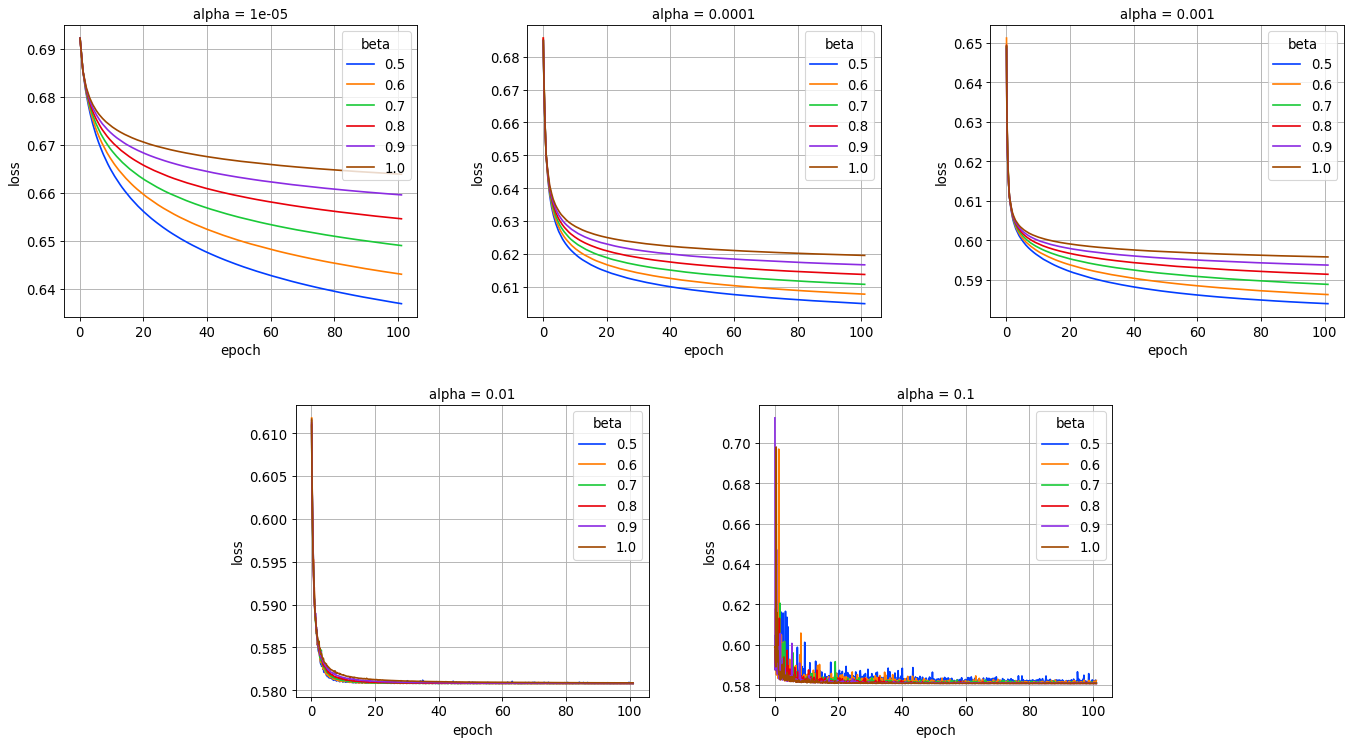

In [688]:
axis = []
plt.figure(figsize=(20, 12), dpi=80)
axis.append(plt.subplot2grid((2, 6), (0, 0), colspan=2))
axis.append(plt.subplot2grid((2, 6), (0, 2), colspan=2))
axis.append(plt.subplot2grid((2, 6), (0, 4), colspan=2)) 
axis.append(plt.subplot2grid((2, 6), (1, 1), colspan=2)) 
axis.append(plt.subplot2grid((2, 6), (1, 3), colspan=2)) 

plt.subplots_adjust(left=0.1,
                            bottom=0.1,
                            right=0.9,
                            top=0.8,
                            wspace=0.9,
                            hspace=0.3)
matplotlib.rcParams["legend.loc"] = 'upper right'

for i in range(len(alpha_beta_dfs)):
    ax = axis[i]
    grid = sns.lineplot(data = sgd_alpha_beta_dfs[i], x = 'epoch', y = 'loss', hue = 'beta',  
                    palette='bright', ax=ax)
    ax.set_title('alpha = ' + str(alphas[i]))
    ax.grid(True)
    
plt.savefig('charts/SGD_alpha_beta.pdf')

plt.show()

In [42]:
gsd_hist_alpha_beta1 = {}
for alpha in (alphas):
    print(alpha)
    gsd_hist_alpha_beta1[alpha] = {}
    for beta in (betas):
        print(beta, end=' ')
        hist = (SGDClassifier('binary_logistic', step_alpha=alpha, step_beta=beta, max_iter = 100, batch_size=128)
                        .fit(X_train_vectorized, y_train.to_numpy(), trace=True, consider_tolerance = False, log_freq=0.1))
        acc = np.array(hist['accuracy'])
        times = np.array(hist['epoch_num'])
        gsd_hist_alpha_beta1[alpha][beta] = np.hstack((times.reshape(-1,1),acc.reshape(-1,1)))
    print()

1e-05
0.5 0.6 0.7 0.8 0.9 1.0 
0.0001
0.5 0.6 0.7 0.8 0.9 1.0 
0.001
0.5 0.6 0.7 0.8 0.9 1.0 
0.01
0.5 0.6 0.7 0.8 0.9 1.0 
0.1
0.5 0.6 0.7 0.8 0.9 1.0 


In [43]:
gsd_alpha_beta_dfs1 = []
for alpha in alphas:
    dfs = []
    for beta in betas:
        times = gsd_hist_alpha_beta1[alpha][beta][:,0]
        acc = gsd_hist_alpha_beta1[alpha][beta][:,1]
        df = pd.DataFrame()
        df['accuracy'] = acc
        df['epoch'] = times
        df['beta'] = beta
        
        dfs.append(df)
        
    gsd_alpha_beta_dfs1.append(pd.concat(dfs, axis=0).reset_index().drop('index', axis=1))

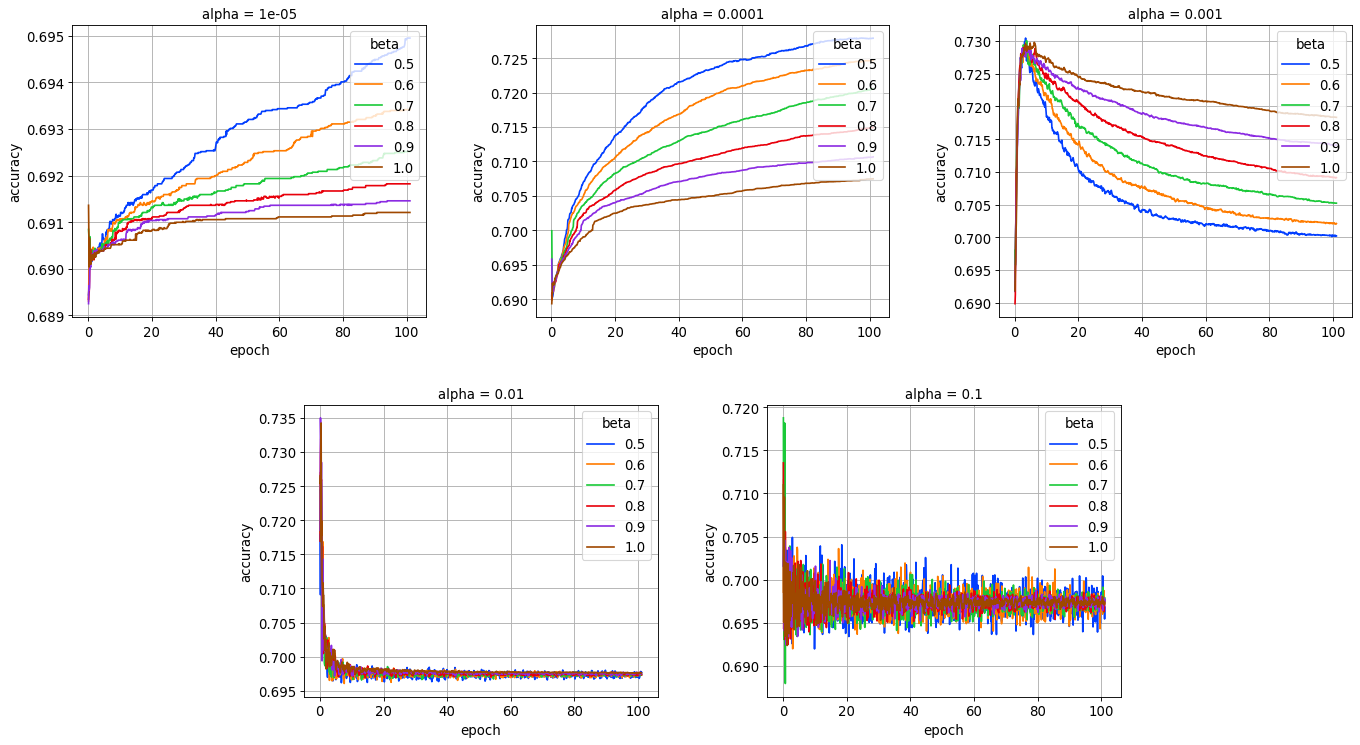

In [690]:
axis = []
plt.figure(figsize=(20, 12), dpi=80)
axis.append(plt.subplot2grid((2, 6), (0, 0), colspan=2))
axis.append(plt.subplot2grid((2, 6), (0, 2), colspan=2))
axis.append(plt.subplot2grid((2, 6), (0, 4), colspan=2)) 
axis.append(plt.subplot2grid((2, 6), (1, 1), colspan=2)) 
axis.append(plt.subplot2grid((2, 6), (1, 3), colspan=2)) 


plt.subplots_adjust(left=0.1,
                            bottom=0.1,
                            right=0.9,
                            top=0.8,
                            wspace=0.9,
                            hspace=0.3)
matplotlib.rcParams["legend.loc"] = 'upper right'

for i in range(len(alpha_beta_dfs)):
    ax = axis[i]
    grid = sns.lineplot(data = gsd_alpha_beta_dfs1[i], x = 'epoch', y = 'accuracy', hue = 'beta',  
                    palette='bright', ax=ax)
    ax.set_title('alpha = ' + str(alphas[i]))
    ax.grid(True)
    
plt.savefig('charts/SGD_alpha_beta1.pdf')

plt.show()

In [86]:
best_sgd_alpha = 0.01
best_sgd_beta = 1

In [87]:
sgd_hist_weights = []
for w_0 in tqdm(weights):
    loss = []
    times = []
    if not w_0 is None:
        hist = (SGDClassifier('binary_logistic', step_alpha=best_sgd_alpha, step_beta=best_sgd_beta, max_iter = 40, batch_size=128)
                        .fit(X_train_vectorized, y_train.to_numpy(),w_0=w_0[1:], b = w_0[0], trace=True, log_freq=0.1))
    else:
        hist = (SGDClassifier('binary_logistic', step_alpha=best_sgd_alpha, step_beta=best_sgd_beta, max_iter = 40, batch_size=128)
                .fit(X_train_vectorized, y_train.to_numpy(), trace=True, log_freq=0.1))
        
    loss = np.array(hist['func'])
    times = np.array(hist['epoch_num'])
    sgd_hist_weights.append(np.hstack((times.reshape(-1,1),loss.reshape(-1,1))))

100%|██████████████████████████████████████| 5/5 [00:08<00:00,  1.76s/it]


In [88]:
sgd_weights_dfs = []
names = ['$zeros$','$Normal(0,1)$', '$Uniform(-1,1)$' ,'$scalar$ $product$', '$default$']
for i in range(len(names)):
    times = sgd_hist_weights[i][:,0]
    loss = sgd_hist_weights[i][:,1]
    df = pd.DataFrame()
    df['loss'] = loss
    df['epoch'] = times
    df['Initial approximation'] = names[i]
    sgd_weights_dfs.append(df)


sgd_weights_df = pd.concat(sgd_weights_dfs, axis=0).reset_index().drop('index', axis=1)

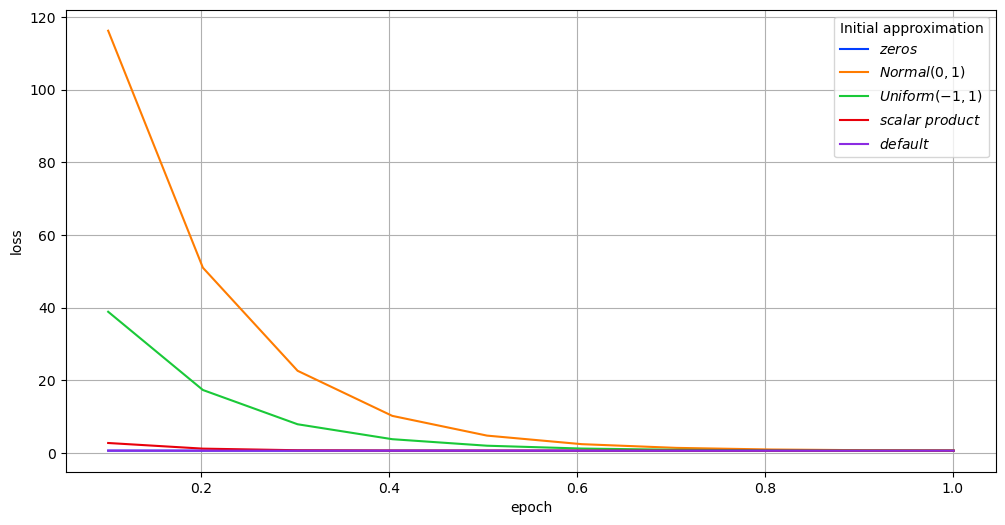

In [89]:
figure, axis = plt.subplots(1, 1, figsize=(12, 6))
matplotlib.rcParams["legend.loc"] = 'upper right'

grid = sns.lineplot(data = sgd_weights_df, x = 'epoch', y = 'loss', hue = 'Initial approximation',  
                    palette='bright', ax=axis)

axis.grid(True)

plt.show()

In [90]:
sgd_hist_weights1 = []
for w_0 in tqdm(weights):
    loss = []
    times = []
    if not w_0 is None:
        hist = (SGDClassifier('binary_logistic', step_alpha=best_sgd_alpha, step_beta=best_sgd_beta, max_iter = 40, batch_size=128)
                        .fit(X_train_vectorized, y_train.to_numpy(),w_0=w_0[1:], b = w_0[0], trace=True, log_freq=0.1))
    else:
        hist = (SGDClassifier('binary_logistic', step_alpha=best_sgd_alpha, step_beta=best_sgd_beta, max_iter = 40, batch_size=128)
                .fit(X_train_vectorized, y_train.to_numpy(), trace=True, log_freq=0.1))
        
    acc = np.array(hist['accuracy'])
    times = np.array(hist['epoch_num'])
    sgd_hist_weights1.append(np.hstack((times.reshape(-1,1),acc.reshape(-1,1))))

100%|██████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]


In [91]:
sgd_weights_dfs1 = []
names = ['$zeros$','$Normal(0,1)$', '$Uniform(-1,1)$' ,'$scalar$ $product$', '$default$']
for i in range(len(names)):
    times = sgd_hist_weights1[i][:,0]
    acc = sgd_hist_weights1[i][:,1]
    df = pd.DataFrame()
    df['accuracy'] = acc
    df['epoch'] = times
    df['Initial approximation'] = names[i]
    sgd_weights_dfs1.append(df)


sgd_weights_df1 = pd.concat(sgd_weights_dfs1, axis=0).reset_index().drop('index', axis=1)

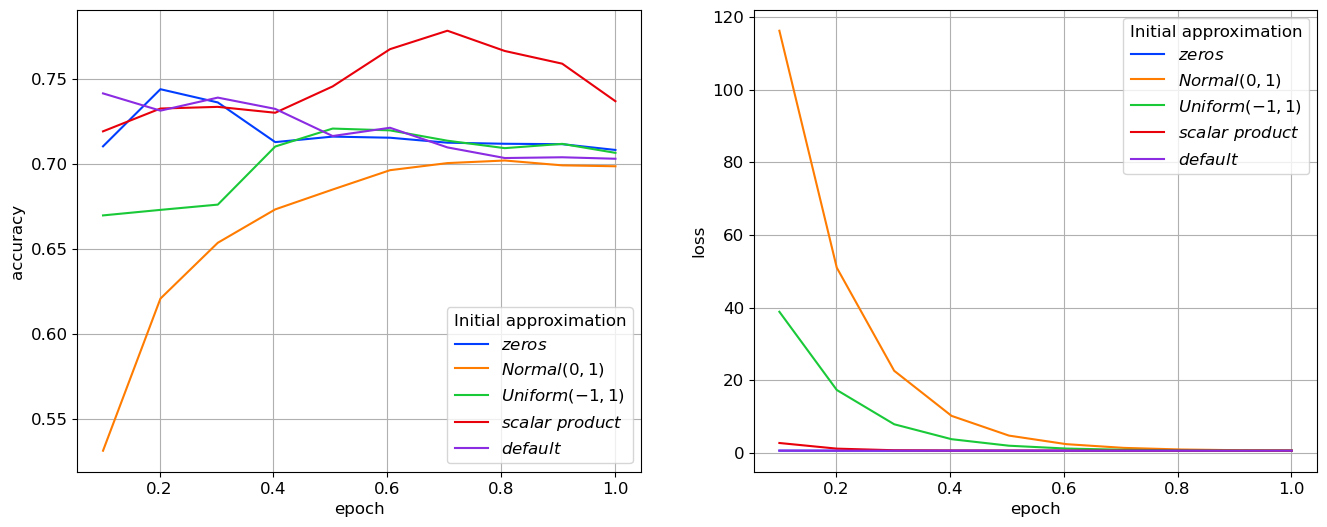

In [697]:
figure, axis = plt.subplots(1, 2, figsize=(16, 6))
matplotlib.rcParams["legend.loc"] = 'upper right'


grid = sns.lineplot(data = sgd_weights_df, x = 'epoch', y = 'loss', hue = 'Initial approximation',  
                    palette='bright', ax=axis[1])

axis[0].grid(True)

matplotlib.rcParams["legend.loc"] = 'lower right'

grid = sns.lineplot(data = sgd_weights_df1, x = 'epoch', y = 'accuracy', hue = 'Initial approximation',  
                    palette='bright', ax=axis[0])

axis[1].grid(True)

plt.savefig('charts/SGD_w0.pdf')

plt.show()

In [706]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
batch_sizes

[32, 64, 128, 256, 512, 1024]

In [707]:
sgd_hist_batches = []
for batch_size in tqdm(batch_sizes):
    loss = []
    times = []
    hist = (SGDClassifier('binary_logistic', step_alpha=best_sgd_alpha, step_beta=best_sgd_beta, batch_size=int(batch_size))
            .fit(X_train_vectorized, y_train.to_numpy(),w_0=w3[1:], b = w3[0], trace=True, log_freq=0.1))
    
        
    loss = np.array(hist['func'])
    times = np.array(hist['epoch_num'])
    sgd_hist_batches.append(np.hstack((times.reshape(-1,1), loss.reshape(-1,1))))

100%|██████████████████████████████████████| 6/6 [01:00<00:00, 10.05s/it]


In [708]:
sgd_batches_dfs = []
for i in range(len(batch_sizes)):
    times = sgd_hist_batches[i][:,0]
    loss = sgd_hist_batches[i][:,1]
    df = pd.DataFrame()
    df['loss'] = loss
    df['epoch'] = times
    df['Batch size'] = int(batch_sizes[i])
    sgd_batches_dfs.append(df)


sgd_batches_df = pd.concat(sgd_batches_dfs, axis=0).reset_index().drop('index', axis=1)

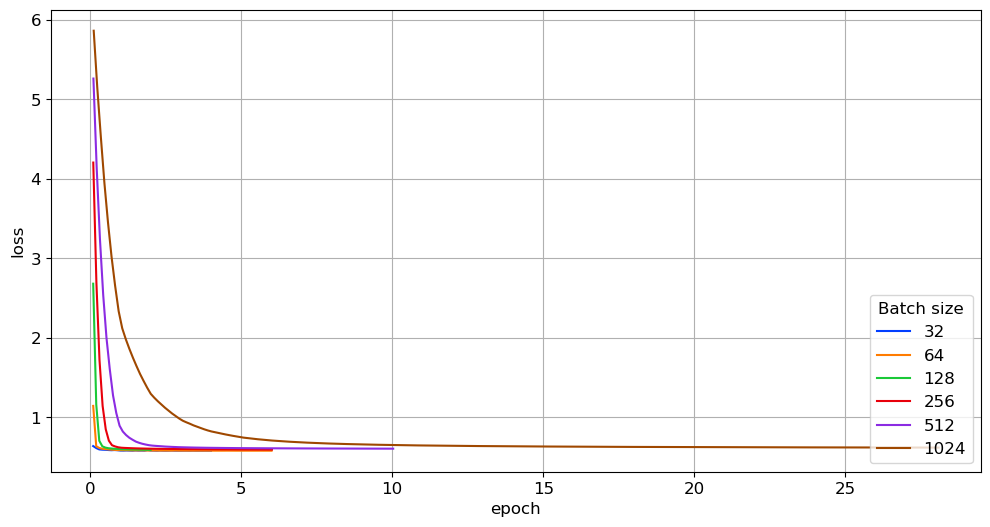

In [709]:
figure, axis = plt.subplots(1, 1, figsize=(12, 6))
matplotlib.rcParams["legend.loc"] = 'lower right'

grid = sns.lineplot(data = sgd_batches_df, x = 'epoch', y = 'loss', hue = 'Batch size',  
                    palette='bright', ax=axis)

axis.grid(True)

plt.show()

In [710]:
sgd_hist_batches1 = []
for batch_size in tqdm(batch_sizes):
    acc = []
    times = []
    hist = (SGDClassifier('binary_logistic', step_alpha=best_sgd_alpha, step_beta=best_sgd_beta, batch_size=int(batch_size))
            .fit(X_train_vectorized, y_train.to_numpy(),w_0=w3[1:], b = w3[0], trace=True, log_freq=0.1))
    
        
    acc = np.array(hist['accuracy'])
    times = np.array(hist['epoch_num'])
    sgd_hist_batches1.append(np.hstack((times.reshape(-1,1), acc.reshape(-1,1))))

100%|██████████████████████████████████████| 6/6 [01:16<00:00, 12.77s/it]


In [711]:
sgd_batches_dfs1 = []
for i in range(len(batch_sizes)):
    times = sgd_hist_batches1[i][:,0]
    acc = sgd_hist_batches1[i][:,1]
    df = pd.DataFrame()
    df['accuracy'] = acc
    df['epoch'] = times
    df['Batch size'] = int(batch_sizes[i])
    sgd_batches_dfs1.append(df)


sgd_batches_df1 = pd.concat(sgd_batches_dfs1, axis=0).reset_index().drop('index', axis=1)

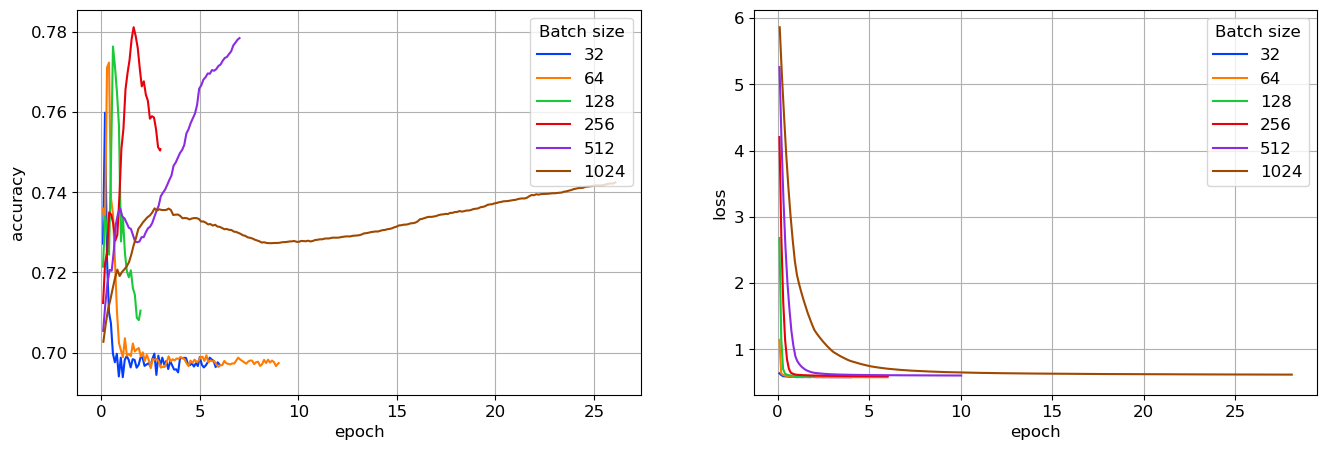

In [712]:
figure, axis = plt.subplots(1, 2, figsize=(16, 5))
matplotlib.rcParams["legend.loc"] = 'upper right'

grid = sns.lineplot(data = sgd_batches_df1, x = 'epoch', y = 'accuracy', hue = 'Batch size',  
                    palette='bright', ax=axis[0])

axis[0].grid(True)

grid = sns.lineplot(data = sgd_batches_df, x = 'epoch', y = 'loss', hue = 'Batch size',  
                    palette='bright', ax=axis[1])

axis[1].grid(True)

plt.savefig('charts/SGD_batch.pdf')

plt.show()

In [713]:
best_batch = 256

In [108]:
l2_coefs = np.logspace(-6,0,7)
hist_reg = {}
for l2_coef in tqdm(l2_coefs):
    clf1 = SGDClassifier('binary_logistic', step_alpha=best_sgd_alpha, step_beta=best_sgd_beta, l2_coef=l2_coef, batch_size=best_batch)
    hist = clf1.fit(X_train_vectorized, y_train, w_0=w3[1:], b = w3[0], trace=True, log_freq=0.1)
    loss = np.array(hist['func'])
    times = np.arange(len(acc))
    hist_reg[l2_coef] = np.hstack((times.reshape(-1,1),loss.reshape(-1,1)))

100%|██████████████████████████████████████| 7/7 [00:15<00:00,  2.18s/it]


In [723]:
l2_dfs = []
for l2_coef in l2_coefs:
    times = hist_reg[l2_coef][:,0]
    loss = hist_reg[l2_coef][:,1]
    df = pd.DataFrame()
    df['loss'] = loss
    df['epoch'] = times
    df['Regularization parameter'] = l2_coef
    l2_dfs.append(df)


l2_df = pd.concat(l2_dfs, axis=0).reset_index().drop('index', axis=1)

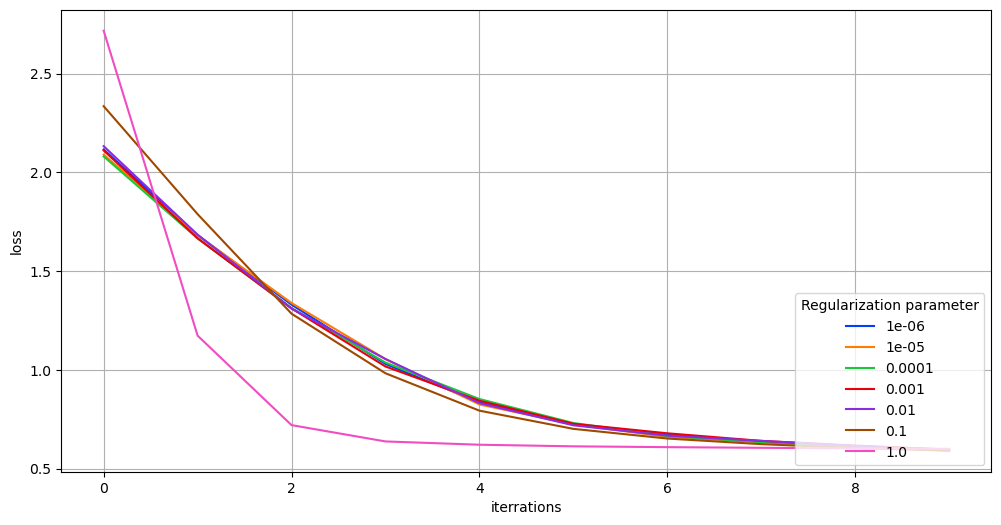

In [110]:
figure, axis = plt.subplots(1, 1, figsize=(12, 6))
matplotlib.rcParams["legend.loc"] = 'lower right'

grid = sns.lineplot(data = l2_df, x = 'iterrations', y = 'loss', hue = 'Regularization parameter',  
                    palette='bright', ax=axis)

axis.grid(True)

plt.show()

In [111]:
l2_coefs = np.logspace(-6,0,7)
hist_reg_acc = {}
for l2_coef in tqdm(l2_coefs):
    clf1 = SGDClassifier('binary_logistic', step_alpha=best_sgd_alpha, step_beta=best_sgd_beta, l2_coef=l2_coef, batch_size=best_batch)
    hist = clf1.fit(X_train_vectorized, y_train, w_0=w3[1:], b = w3[0], trace=True, log_freq=0.1)
    acc = np.array(hist['accuracy'])
    times = np.arange(len(acc))
    hist_reg_acc[l2_coef] = np.hstack((times.reshape(-1,1),acc.reshape(-1,1)))

100%|██████████████████████████████████████| 7/7 [00:15<00:00,  2.17s/it]


In [721]:
l2_dfs_acc = []
for l2_coef in l2_coefs:
    times = hist_reg_acc[l2_coef][:,0]
    acc = hist_reg_acc[l2_coef][:,1]
    df = pd.DataFrame()
    df['accuracy'] = acc
    df['epoch'] = times
    df['Regularization parameter'] = l2_coef
    l2_dfs_acc.append(df)


l2_df_acc = pd.concat(l2_dfs_acc, axis=0).reset_index().drop('index', axis=1)

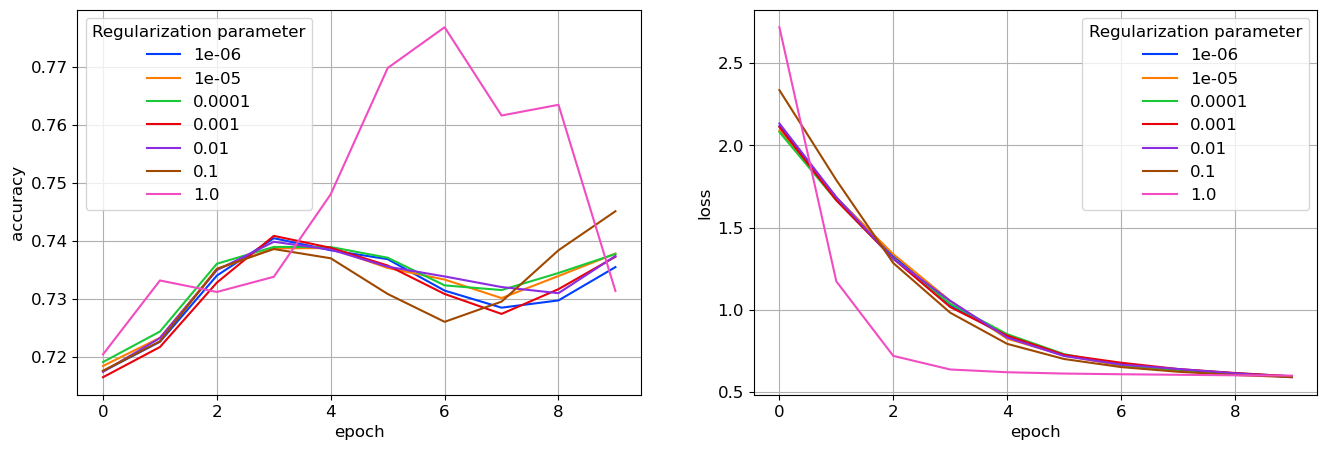

In [724]:
figure, axis = plt.subplots(1, 2, figsize=(16, 5))
matplotlib.rcParams["legend.loc"] = 'upper left'

grid = sns.lineplot(data = l2_df_acc, x = 'epoch', y = 'accuracy', hue = 'Regularization parameter',  
                    palette='bright', ax=axis[0])

axis[0].grid(True)

matplotlib.rcParams["legend.loc"] = 'upper right'

grid = sns.lineplot(data = l2_df, x = 'epoch', y = 'loss', hue = 'Regularization parameter',  
                    palette='bright', ax=axis[1])

axis[1].grid(True)

plt.savefig('charts/l2_coef.pdf')

plt.show()

In [726]:
best_l2 = 1

## Итог

In [727]:
%%time
clf1 = GDClassifier('binary_logistic', tolerance = 1e-5, step_alpha=best_alpha, step_beta=best_beta, l2_coef = best_l2, max_iter=100)
hist11 = clf1.fit(X_train_vectorized, y_train, w_0=w3[1:], b = w3[0], teach_bias=True, trace = True)
y_pred = clf1.predict(X_train_vectorized)
print('Best GDCclassifier score: ', np.sum(y_pred == y_train)/len(y_train) )

Best GDCclassifier score:  0.7274159159447571
CPU times: user 9.83 s, sys: 929 ms, total: 10.8 s
Wall time: 10.8 s


In [728]:
%%time
clf1 = GDClassifier('binary_logistic', tolerance = 1e-5, step_alpha=best_alpha, step_beta=best_beta, l2_coef = best_l2, max_iter=100)
hist12 = clf1.fit(X_train_vectorized, y_train, w_0=w3[1:], b = w3[0], teach_bias=False, trace = True)
y_pred = clf1.predict(X_train_vectorized)
print('Best GDCclassifier score: ', np.sum(y_pred == y_train)/len(y_train) )

Best GDCclassifier score:  0.7732467682142102
CPU times: user 9.81 s, sys: 871 ms, total: 10.7 s
Wall time: 10.7 s


In [729]:
%%time
clf2 = SGDClassifier('binary_logistic', tolerance = 1e-5, step_alpha=best_sgd_alpha, step_beta=best_sgd_beta, batch_size=best_batch, l2_coef = best_l2, max_iter=10)
hist21= clf2.fit(X_train_vectorized, y_train, w_0=w3[1:], b = w3[0], teach_bias=True, trace=True, log_freq=0.1, consider_tolerance=False)
y_pred = clf2.predict(X_train_vectorized)
print('Best SGDCclassifier score: ', np.sum(y_pred == y_train)/len(y_train) )

Best SGDCclassifier score:  0.7095330477708841
CPU times: user 11.1 s, sys: 73.7 ms, total: 11.2 s
Wall time: 11.2 s


In [730]:
%%time
clf2 = SGDClassifier('binary_logistic', step_alpha=best_sgd_alpha, step_beta=best_sgd_beta, batch_size=best_batch, l2_coef = best_l2, max_iter=10)
hist22 = clf2.fit(X_train_vectorized, y_train, w_0=w3[1:], b = w3[0], teach_bias=False, trace=True, log_freq=0.1, consider_tolerance=False)
y_pred = clf2.predict(X_train_vectorized)
print('Best SGDCclassifier score: ', np.sum(y_pred == y_train)/len(y_train) )

Best SGDCclassifier score:  0.7781832849926048
CPU times: user 11.1 s, sys: 80.1 ms, total: 11.2 s
Wall time: 11.2 s


In [731]:
bias_dfs = []

df = pd.DataFrame()
df['loss'] = hist11['func']
df['accuracy'] = hist11['accuracy']
df['iterrations'] = np.arange(len(hist11['func']))
df['kind'] = 'GDC (b = True)'
bias_dfs.append(df)

df = pd.DataFrame()
df['loss'] = hist12['func']
df['accuracy'] = hist12['accuracy']
df['iterrations'] = np.arange(len(hist12['func']))
df['kind'] = 'GDC (b = False)'
bias_dfs.append(df)

df = pd.DataFrame()
df['loss'] = hist21['func']
df['accuracy'] = hist21['accuracy']
df['iterrations'] = np.arange(len(hist21['func']))
df['kind'] = 'SGDC (b = True)'
bias_dfs.append(df)

df = pd.DataFrame()
df['loss'] = hist22['func']
df['accuracy'] = hist22['accuracy']
df['iterrations'] = np.arange(len(hist22['func']))
df['kind'] = 'SGDC (b = False)'
bias_dfs.append(df)

bias_df = pd.concat(bias_dfs, axis=0).reset_index().drop('index', axis=1)

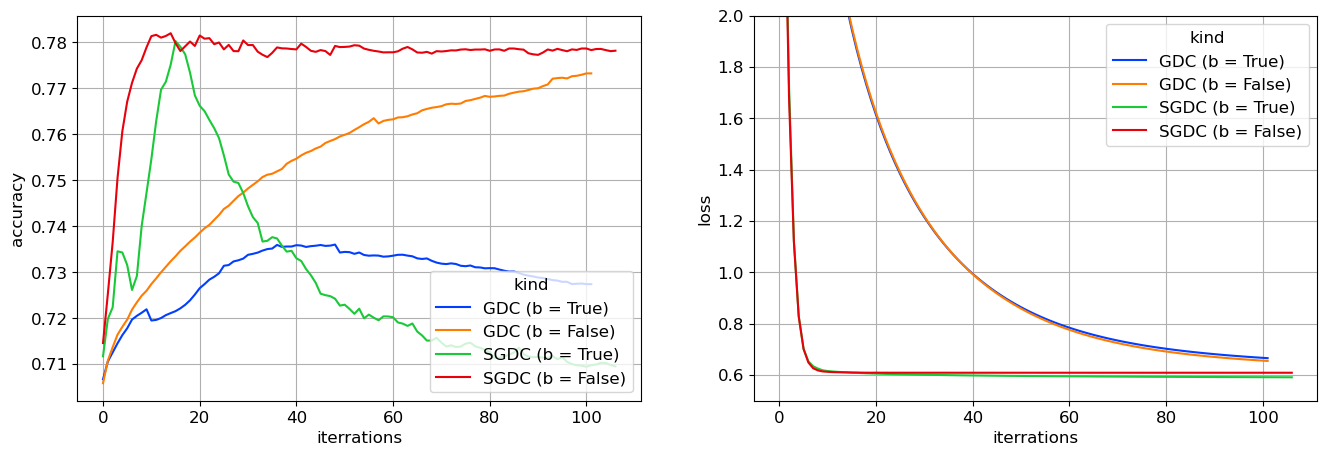

In [732]:
figure, axis = plt.subplots(1, 2, figsize=(16, 5))
matplotlib.rcParams["legend.loc"] = 'lower right'

grid = sns.lineplot(data = bias_df, x = 'iterrations', y = 'accuracy', hue = 'kind',  
                    palette='bright', ax=axis[0])

axis[0].grid(True)

matplotlib.rcParams["legend.loc"] = 'upper right'

grid = sns.lineplot(data = bias_df, x = 'iterrations', y = 'loss', hue = 'kind',  
                    palette='bright', ax=axis[1])

axis[1].grid(True)
axis[1].set_ylim(0.5,2)
plt.savefig('charts/bias.pdf')

plt.show()

In [733]:
%%time
clf2 = SGDClassifier('binary_logistic', step_alpha=best_sgd_alpha, step_beta=best_sgd_beta, batch_size=best_batch, l2_coef = best_l2, max_iter=10)
hist22 = clf2.fit(X_train_vectorized, y_train, w_0=w3[1:], b = w3[0], teach_bias=False, trace=True, log_freq=0.1, consider_tolerance=False)
y_pred = clf2.predict(X_train_vectorized)
print('Best SGDCclassifier score: ', np.sum(y_pred == y_train)/len(y_train) )

Best SGDCclassifier score:  0.7785482414859491
CPU times: user 11 s, sys: 96.5 ms, total: 11.1 s
Wall time: 11.2 s


In [734]:
pos_train_probs = clf2.predict_proba(X_train_vectorized)[:,1]
accuracy_t = []
ts = np.linspace(0.3, 0.7, 25)
for t in ts:
    y_pred = (pos_train_probs >= t)* 2 - 1
    accuracy_t.append(np.sum(y_pred == y_train)/len(y_train))

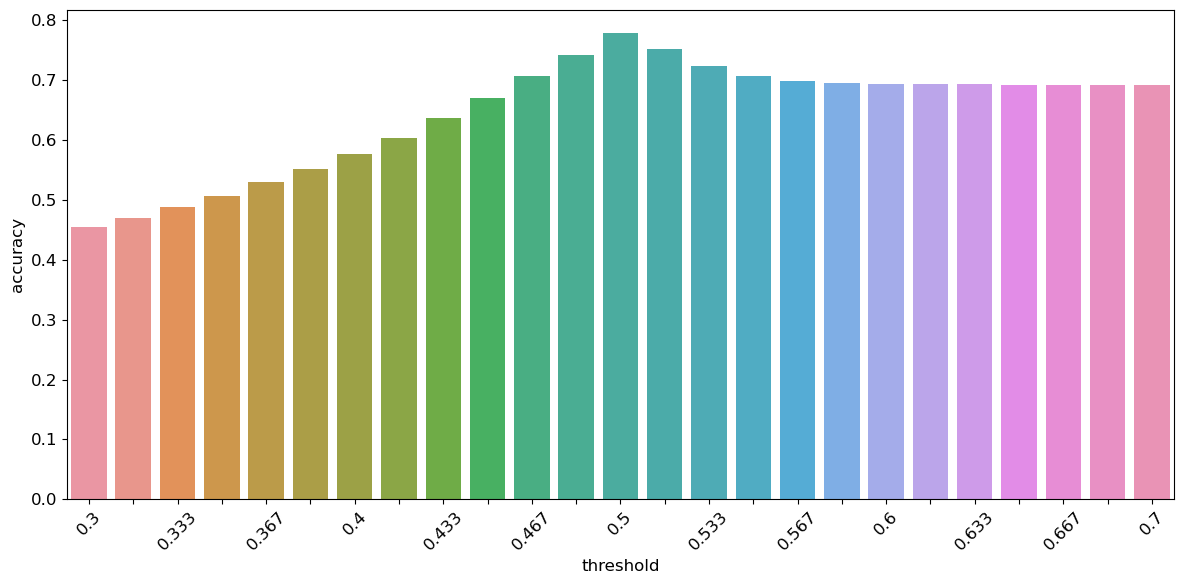

In [740]:
figure, axis = plt.subplots(1, 1, figsize=(12, 6))
sns.barplot(x=ts, y = accuracy_t, ax = axis)
axis.set_xticks(ticks = np.arange(len(ts)), labels=[round(e,3) if i%2==0 else '' for i,e in enumerate(ts)],rotation = 45)
axis.set_xlabel('threshold')
axis.set_ylabel('accuracy')
plt.tight_layout()
plt.savefig('charts/threshold.pdf')
plt.show()

In [875]:
%%time
clf1 = GDClassifier('binary_logistic', step_alpha=best_alpha, step_beta=best_beta, l2_coef = best_l2)
hist = clf1.fit(X_train_vectorized, y_train, w_0=w3[1:], b = w3[0], teach_bias=False)
y_pred = clf1.predict(X_test_vectorized)
print('Best GDCclassifier score: ', np.sum(y_pred == y_test)/len(y_test) )

Best GDCclassifier score:  0.7636873669955504
CPU times: user 32.8 s, sys: 3.25 s, total: 36.1 s
Wall time: 36.2 s


In [876]:
%%time
clf2 = SGDClassifier('binary_logistic', step_alpha=best_sgd_alpha, step_beta=best_sgd_beta, batch_size=best_batch, l2_coef = best_l2)
clf2.fit(X_train_vectorized, y_train, w_0=w3[1:], b = w3[0], teach_bias=False)
y_pred = clf1.predict(X_test_vectorized)
print('Best GDCclassifier score: ', np.sum(y_pred == y_test)/len(y_test) )

Best GDCclassifier score:  0.7636873669955504
CPU times: user 4.14 s, sys: 120 ms, total: 4.26 s
Wall time: 4.31 s


# 4 Работа с данными

In [743]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [294]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

In [751]:
for i in stop_words:
    print(i + ', ', end = '')

i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, must

In [752]:
def prepare_text(text):
    s = ''
    for w in text.split(' '):
        if not w in stop_words:
            s += ' ' + lemmatizer.lemmatize(w)
    return s.strip()

X_train_lemmatized = X_train['comment_text'].apply(prepare_text)
X_test_lemmatized = X_test['comment_text'].apply(prepare_text)

In [753]:
X_train.iloc[4:7]['comment_text'].to_numpy()


array(['you sir are my hero any chance you remember what page that s on',
       'congratulations from me as well use the tools well talk',
       'cocksucker before you piss around on my work'], dtype=object)

In [755]:
X_train_vectorized

<52061x568 sparse matrix of type '<class 'numpy.int64'>'
	with 1319021 stored elements in Compressed Sparse Row format>

In [754]:
X_train_lemmatized[4:7].to_numpy()

array(['sir hero chance remember page',
       'congratulation well use tool well talk',
       'cocksucker piss around work'], dtype=object)

In [758]:
vectorizer = CountVectorizer(lowercase=False, min_df=0.01)
X_train_lemmatized_vectorized = vectorizer.fit_transform(X_train_lemmatized)
X_test_lemmatized_vectorized = vectorizer.transform(X_test_lemmatized)

In [759]:
X_train_lemmatized_vectorized

<52061x456 sparse matrix of type '<class 'numpy.int64'>'
	with 601023 stored elements in Compressed Sparse Row format>

In [760]:
w31 = np.zeros(X_train_lemmatized_vectorized.shape[1]+1)
for i in range(X_train_lemmatized_vectorized.shape[1]):
    w31[i+1] = (np.dot(X_train_lemmatized_vectorized[:,i].A.T, y_train) / np.dot(y_train, y_train))[0]

In [761]:
%%time
clf1 = GDClassifier('binary_logistic', step_alpha=best_alpha, step_beta=best_beta, l2_coef = best_l2)
clf1.fit(X_train_lemmatized_vectorized, y_train, w_0=w31[1:], b = w31[0], teach_bias=False)
y_pred = clf1.predict(X_test_lemmatized_vectorized)
print('Best GDCclassifier score: ', np.sum(y_pred == y_test)/len(y_test) )

Best GDCclassifier score:  0.7974946798220158
CPU times: user 8.27 s, sys: 615 ms, total: 8.89 s
Wall time: 8.96 s


In [764]:
%%time
clf2 = SGDClassifier('binary_logistic', step_alpha=best_sgd_alpha, step_beta=best_sgd_beta, batch_size=best_batch, l2_coef = best_l2)
clf2.fit(X_train_lemmatized_vectorized, y_train, w_0=w31[1:], b = w31[0], teach_bias=False)
y_pred = clf2.predict(X_test_lemmatized_vectorized)
print('Best SGDCclassifier score: ', np.sum(y_pred == y_test)/len(y_test) )

Best SGDCclassifier score:  0.7947378603211452
CPU times: user 1.55 s, sys: 15.8 ms, total: 1.57 s
Wall time: 1.61 s


In [303]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [304]:
tf_vectorizer = TfidfVectorizer()

In [305]:
X_train_lemmatized_tfvectorized = tf_vectorizer.fit_transform(X_train_lemmatized)
X_test_lemmatized_tfvectorized = tf_vectorizer.transform(X_test_lemmatized)

In [306]:
X_train_lemmatized_tfvectorized

<52061x82876 sparse matrix of type '<class 'numpy.float64'>'
	with 1330820 stored elements in Compressed Sparse Row format>

In [311]:
%%time
clf2 = SGDClassifier('binary_logistic', step_alpha=best_sgd_alpha, step_beta=best_sgd_beta, batch_size=best_batch, l2_coef = best_l2)
clf2.fit(X_train_lemmatized_tfvectorized, y_train, w_0=np.zeros(X_test_lemmatized_tfvectorized.shape[1]), b = 0)
y_pred = (clf2.predict_proba(X_test_lemmatized_vectorized)[:,1]>=best_t)*2-1
print('Best SGDCclassifier score: ', np.sum(y_pred == y_test)/len(y_test) )

Best SGDCclassifier score:  0.702070032888373
CPU times: user 5.84 s, sys: 288 ms, total: 6.13 s
Wall time: 6.04 s


## Maxdf и Mindf

### Bag of words

In [775]:
mindfs = np.logspace(-5, -1, 10)
sgd_min_dfs = []
mindfs_times = []
mindfs_shapes = []
for mindf in tqdm(mindfs):
    vectorizer = CountVectorizer(lowercase=False, min_df = mindf)
    X_train_lemmatized_vectorized = vectorizer.fit_transform(X_train_lemmatized)
    clf2 = SGDClassifier('binary_logistic', step_alpha=best_sgd_alpha, step_beta=best_sgd_beta, batch_size=best_batch, l2_coef = best_l2)
    hist = clf2.fit(X_train_lemmatized_vectorized, y_train, w_0=np.zeros(X_train_lemmatized_vectorized.shape[1]), b = 0, trace = True, log_freq = 0.1, teach_bias=False)
    acc = np.array(hist['accuracy'])
    epoch = np.array(hist['epoch_num'])
    mindfs_times.append(np.array((hist['time'])).cumsum()[-1])
    mindfs_shapes.append(X_train_lemmatized_vectorized.shape[1])
    sgd_min_dfs.append(np.hstack((epoch.reshape(-1,1),acc.reshape(-1,1))))

100%|████████████████████████████████████| 10/10 [00:24<00:00,  2.42s/it]


In [776]:
sgd_min_dataframes = []
for i in range(len(mindfs)):
    times = sgd_min_dfs[i][:,0]
    acc = sgd_min_dfs[i][:,1]
    df = pd.DataFrame()
    df['accuracy'] = acc
    df['epoch'] = times
    df['min df'] = f"{mindfs[i]:.5f} ({mindfs_times[i]:.2f}s, d = {mindfs_shapes[i]})"
    sgd_min_dataframes.append(df)


sgd_min_dataframe = pd.concat(sgd_min_dataframes, axis=0).reset_index().drop('index', axis=1)

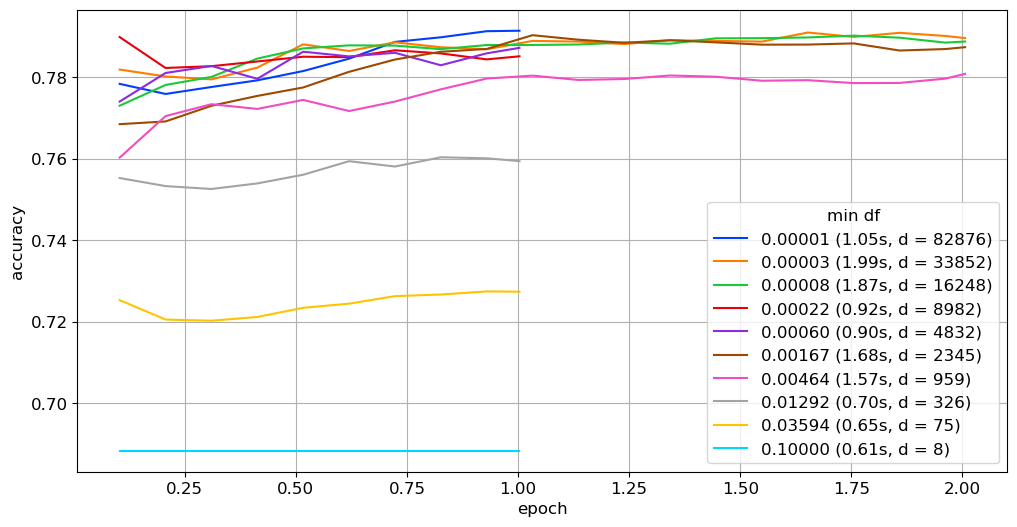

In [778]:
figure, axis = plt.subplots(1, 1, figsize=(12, 6))
matplotlib.rcParams["legend.loc"] = 'lower right'

grid = sns.lineplot(data = sgd_min_dataframe, x = 'epoch', y = 'accuracy', hue = 'min df',  
                    palette='bright', ax=axis)

axis.grid(True)

plt.show()

In [790]:
maxdfs = np.logspace(-3, -1, 6)
sgd_max_dfs = []
maxdfs_times = []
maxdfs_shapes = []
for maxdf in tqdm(maxdfs):
    vectorizer = CountVectorizer(lowercase=False, max_df = maxdf, min_df = 0.0006)
    X_train_lemmatized_vectorized = vectorizer.fit_transform(X_train_lemmatized)
    clf2 = SGDClassifier('binary_logistic', step_alpha=best_sgd_alpha, step_beta=best_sgd_beta, batch_size=best_batch, l2_coef = best_l2)
    hist = clf2.fit(X_train_lemmatized_vectorized, y_train, w_0=np.zeros(X_train_lemmatized_vectorized.shape[1]), b = 0, trace = True, log_freq = 0.1, teach_bias=False)
    acc = np.array(hist['accuracy'])
    epoch = np.array(hist['epoch_num'])
    maxdfs_times.append(np.array((hist['time'])).cumsum()[-1])
    maxdfs_shapes.append(X_train_lemmatized_vectorized.shape[1])
    sgd_max_dfs.append(np.hstack((epoch.reshape(-1,1),acc.reshape(-1,1))))

100%|██████████████████████████████████████| 6/6 [00:11<00:00,  1.99s/it]


In [791]:
sgd_max_dataframes = []
for i in range(len(maxdfs)):
    times = sgd_max_dfs[i][:,0]
    acc = sgd_max_dfs[i][:,1]
    df = pd.DataFrame()
    df['accuracy'] = acc
    df['epoch'] = times
    df['max df'] = f"{maxdfs[i]:.3f} ({maxdfs_times[i]:.2f}s, d = {maxdfs_shapes[i]})"
    sgd_max_dataframes.append(df)


sgd_max_dataframe = pd.concat(sgd_max_dataframes, axis=0).reset_index().drop('index', axis=1)

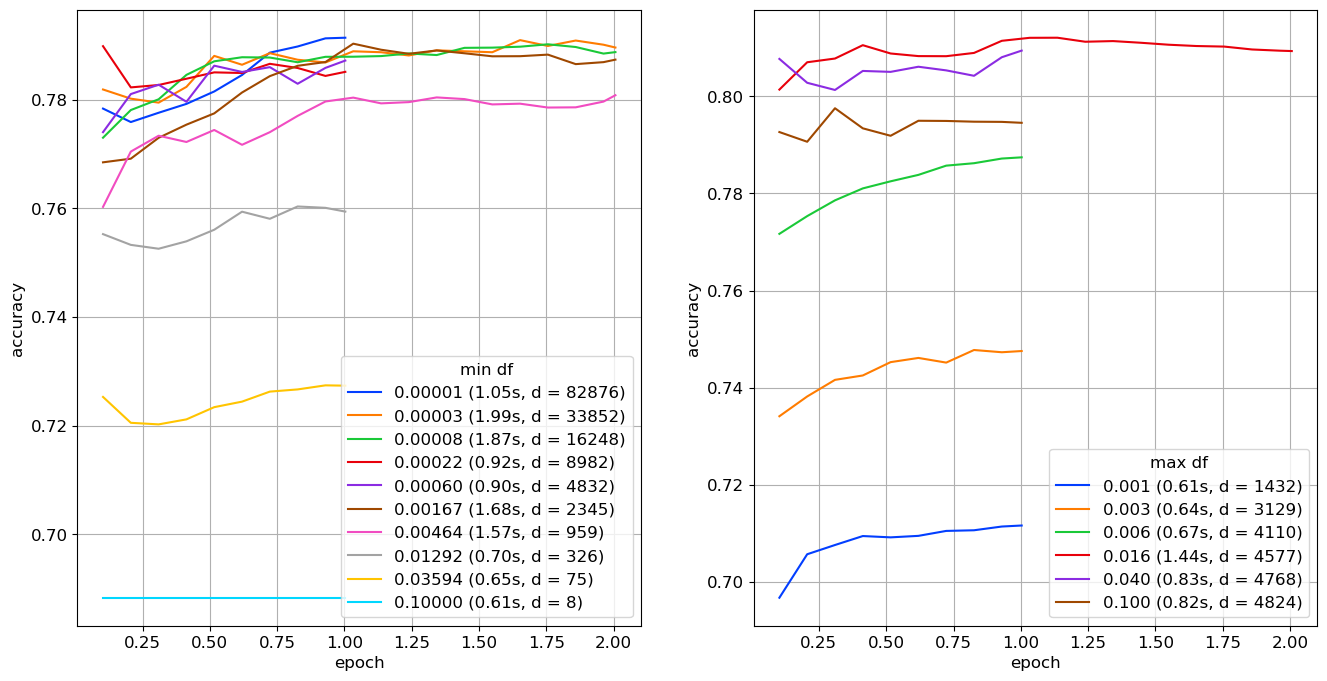

In [792]:
figure, axis = plt.subplots(1, 2, figsize=(16, 8))
matplotlib.rcParams["legend.loc"] = 'lower right'

grid = sns.lineplot(data = sgd_min_dataframe, x = 'epoch', y = 'accuracy', hue = 'min df',  
                    palette='bright', ax=axis[0])

axis[0].grid(True)


grid = sns.lineplot(data = sgd_max_dataframe, x = 'epoch', y = 'accuracy', hue = 'max df',  
                    palette='bright', ax=axis[1])


axis[1].grid(True)

plt.savefig('charts/bag_of_words.pdf')

plt.show()

## TDF

In [794]:
mindfs = np.logspace(-5, -1, 10)
tfsgd_min_dfs = []
tfmindfs_times = []
tfmindfs_shapes = []
for mindf in tqdm(mindfs):
    vectorizer = TfidfVectorizer(lowercase=False, min_df = mindf)
    X_train_lemmatized_vectorized = vectorizer.fit_transform(X_train_lemmatized)
    clf2 = SGDClassifier('binary_logistic', step_alpha=best_sgd_alpha, step_beta=best_sgd_beta, batch_size=best_batch, l2_coef = best_l2)
    hist = clf2.fit(X_train_lemmatized_vectorized, y_train, w_0=np.zeros(X_train_lemmatized_vectorized.shape[1]), b = 0, trace = True, log_freq = 0.01, teach_bias=False)
    acc = np.array(hist['accuracy'])
    epoch = np.array(hist['epoch_num'])
    tfmindfs_times.append(np.array((hist['time'])).cumsum()[-1])
    tfmindfs_shapes.append(X_train_lemmatized_vectorized.shape[1])
    tfsgd_min_dfs.append(np.hstack((epoch.reshape(-1,1),acc.reshape(-1,1))))

100%|████████████████████████████████████| 10/10 [00:22<00:00,  2.25s/it]


In [795]:
tfsgd_min_dataframes = []
for i in range(len(mindfs)):
    times = tfsgd_min_dfs[i][:,0]
    acc = tfsgd_min_dfs[i][:,1]
    df = pd.DataFrame()
    df['accuracy'] = acc
    df['epoch'] = times
    df['min df'] = f"{mindfs[i]:.5f} ({tfmindfs_times[i]:.2f}s, d = {tfmindfs_shapes[i]})"
    tfsgd_min_dataframes.append(df)


tfsgd_min_dataframe = pd.concat(tfsgd_min_dataframes, axis=0).reset_index().drop('index', axis=1)

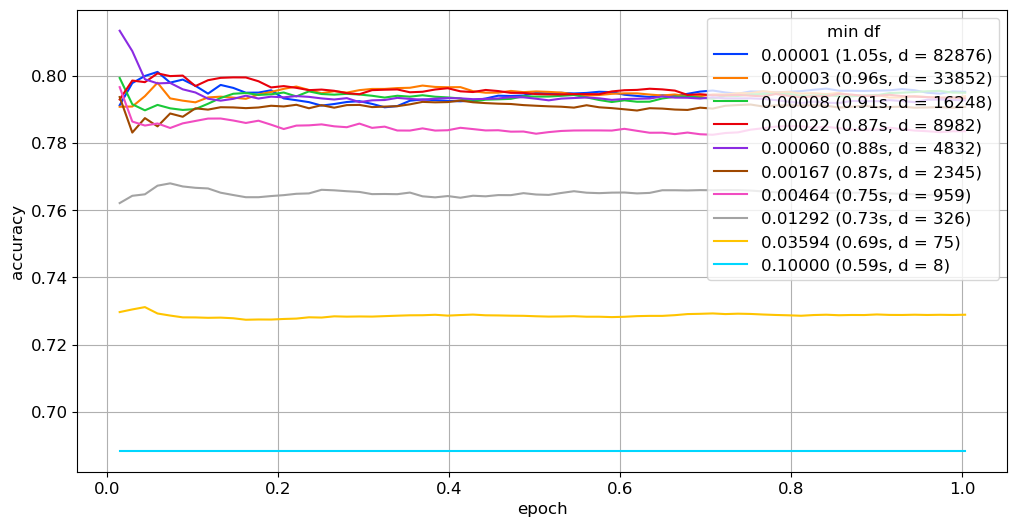

In [796]:
figure, axis = plt.subplots(1, 1, figsize=(12, 6))
matplotlib.rcParams["legend.loc"] = 'upper right'

grid = sns.lineplot(data = tfsgd_min_dataframe, x = 'epoch', y = 'accuracy', hue = 'min df',  
                    palette='bright', ax=axis)

axis.grid(True)
plt.show()

In [822]:
maxdfs = np.logspace(-3, -1, 6)
tfsgd_max_dfs = []
tfmaxdfs_times = []
tfmaxdfs_shapes = []
for maxdf in tqdm(maxdfs):
    vectorizer = TfidfVectorizer(lowercase=False, max_df = maxdf, min_df = 0.0006)
    X_train_lemmatized_vectorized = vectorizer.fit_transform(X_train_lemmatized)
    clf2 = SGDClassifier('binary_logistic', step_alpha=best_sgd_alpha, step_beta=best_sgd_beta, batch_size=best_batch, l2_coef = best_l2)
    hist = clf2.fit(X_train_lemmatized_vectorized, y_train, w_0=np.zeros(X_train_lemmatized_vectorized.shape[1]), b = 0, trace = True, log_freq = 0.1, teach_bias=False)
    acc = np.array(hist['accuracy'])
    epoch = np.array(hist['epoch_num'])
    tfmaxdfs_times.append(np.array((hist['time'])).cumsum()[-1])
    tfmaxdfs_shapes.append(X_train_lemmatized_vectorized.shape[1])
    tfsgd_max_dfs.append(np.hstack((epoch.reshape(-1,1),acc.reshape(-1,1))))

100%|██████████████████████████████████████| 6/6 [00:11<00:00,  1.90s/it]


In [823]:
tfsgd_max_dataframes = []
for i in range(len(maxdfs)):
    times = tfsgd_max_dfs[i][:,0]
    acc = tfsgd_max_dfs[i][:,1]
    df = pd.DataFrame()
    df['accuracy'] = acc
    df['epoch'] = times
    df['max df'] = f"{maxdfs[i]:.3f} ({tfmaxdfs_times[i]:.2f}s, d = {tfmaxdfs_shapes[i]})"
    tfsgd_max_dataframes.append(df)


tfsgd_max_dataframe = pd.concat(tfsgd_max_dataframes, axis=0).reset_index().drop('index', axis=1)

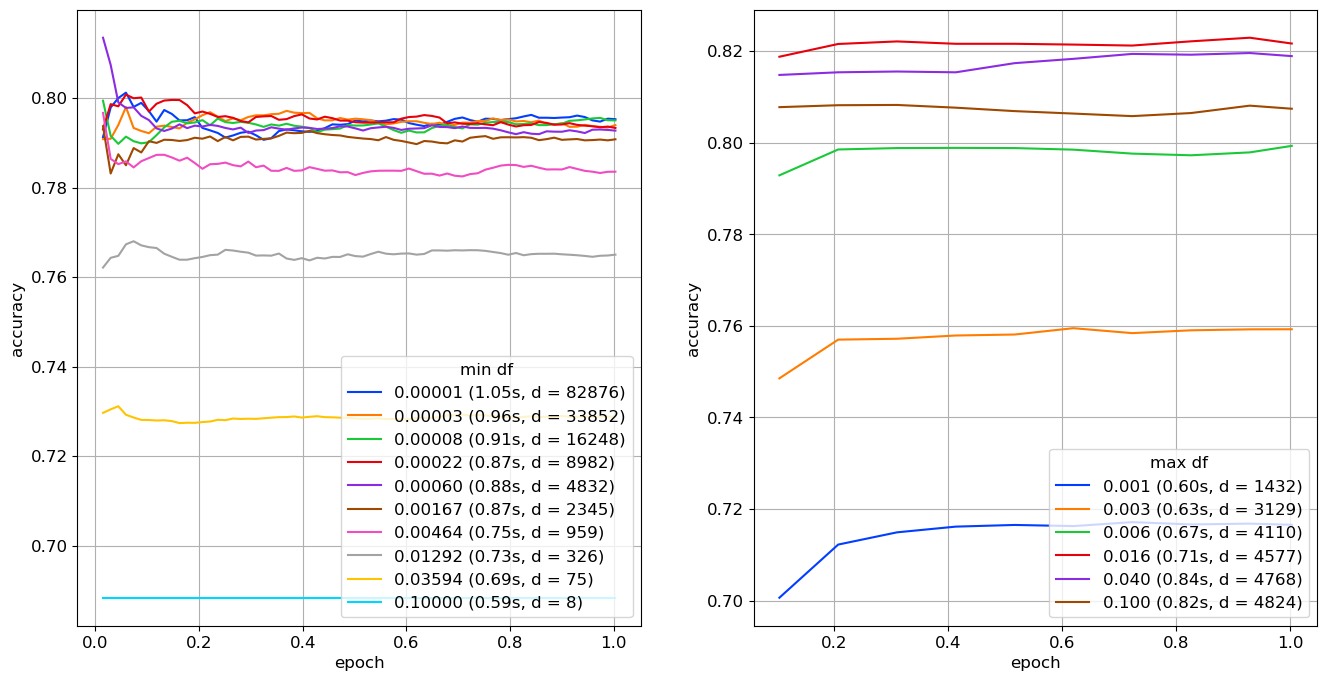

In [827]:
figure, axis = plt.subplots(1, 2, figsize=(16, 8))
matplotlib.rcParams["legend.loc"] = 'lower right'

grid = sns.lineplot(data = tfsgd_min_dataframe, x = 'epoch', y = 'accuracy', hue = 'min df',  
                    palette='bright', ax=axis[0])

axis[0].grid(True)
matplotlib.rcParams["legend.loc"] = 'lower right'

grid = sns.lineplot(data = tfsgd_max_dataframe, x = 'epoch', y = 'accuracy', hue = 'max df',  
                    palette='bright', ax=axis[1])

axis[1].grid(True)

plt.savefig('charts/tfidf.pdf')

plt.show()

In [ ]:
## Итог

In [832]:
vectorizer = CountVectorizer(lowercase=False, max_df = 0.04, min_df = 0.0006)
X_train_lemmatized_vectorized = vectorizer.fit_transform(X_train_lemmatized)
X_test_lemmatized_vectorized = vectorizer.transform(X_test_lemmatized)

In [833]:
X_train_lemmatized_vectorized

<52061x4769 sparse matrix of type '<class 'numpy.int64'>'
	with 881167 stored elements in Compressed Sparse Row format>

In [834]:
w32 = np.zeros(X_train_lemmatized_vectorized.shape[1]+1)
for i in range(X_train_lemmatized_vectorized.shape[1]):
    w32[i+1] = (np.dot(X_train_lemmatized_vectorized[:,i].A.T, y_train) / np.dot(y_train, y_train))[0]

In [838]:
%%time
clf = SGDClassifier('binary_logistic', step_alpha=best_sgd_alpha, step_beta=best_sgd_beta, batch_size=best_batch, l2_coef = best_l2)
clf.fit(X_train_lemmatized_vectorized, y_train, w_0=w32[1:], b = w32[0], teach_bias=False)
y_pred = clf.predict(X_test_lemmatized_vectorized)
print('Best SGDCclassifier score: ', np.sum(y_pred == y_test)/len(y_test) )

Best SGDCclassifier score:  0.8331882375701296
CPU times: user 2.45 s, sys: 50.3 ms, total: 2.5 s
Wall time: 2.51 s


In [840]:
vectorizer = TfidfVectorizer(lowercase=False, max_df = 0.016, min_df = 0.0006)
X_train_lemmatized_vectorized1 = vectorizer.fit_transform(X_train_lemmatized)
X_test_lemmatized_vectorized1 = vectorizer.transform(X_test_lemmatized)

In [841]:
X_train_lemmatized_vectorized1

<52061x4580 sparse matrix of type '<class 'numpy.float64'>'
	with 636557 stored elements in Compressed Sparse Row format>

In [843]:
w33 = np.zeros(X_train_lemmatized_vectorized1.shape[1]+1)
for i in range(X_train_lemmatized_vectorized1.shape[1]):
    w33[i+1] = (np.dot(X_train_lemmatized_vectorized1[:,i].A.T, y_train) / np.dot(y_train, y_train))[0]

In [844]:
%%time
clf = SGDClassifier('binary_logistic', step_alpha=best_sgd_alpha, step_beta=best_sgd_beta, batch_size=best_batch, l2_coef = best_l2)
clf.fit(X_train_lemmatized_vectorized1, y_train, w_0=w33[1:], b = w33[0], teach_bias=False)
y_pred = clf.predict(X_test_lemmatized_vectorized1)
print('Best SGDCclassifier score: ', np.sum(y_pred == y_test)/len(y_test) )

Best SGDCclassifier score:  0.8236119171986844
CPU times: user 754 ms, sys: 28.5 ms, total: 783 ms
Wall time: 801 ms


In [848]:
%%time
best_clf = SGDClassifier('binary_logistic', step_alpha=best_sgd_alpha, step_beta=best_sgd_beta, batch_size=best_batch, l2_coef = best_l2)
best_clf.fit(X_train_lemmatized_vectorized, y_train, w_0=w32[1:], b = w32[0], teach_bias=False)
y_pred = best_clf.predict(X_train_lemmatized_vectorized)
print('Best SGDCclassifier score: ', np.sum(y_pred == y_train)/len(y_train) )

Best SGDCclassifier score:  0.8069188067843491
CPU times: user 1.62 s, sys: 24.4 ms, total: 1.64 s
Wall time: 1.64 s


In [850]:
miss_mask = y_pred != y_train

In [851]:
neg_miss_mask = y_pred[miss_mask] == -1
pos_miss_mask = y_pred[miss_mask] == 1

In [852]:
y_pred[miss_mask][pos_miss_mask][0:50]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [867]:
X_train[miss_mask][pos_miss_mask][0:30]['comment_text'].to_numpy()

array(['good to know about me yeah i m studying now deepu',
       'lmao what a n00b go and listen to manele',
       'know the sex of the foetus',
       'hate is my topic is hate if you hate a person means you like that person your hate can turn into your love',
       'is gonna help us to he is logged in if you want to talk to him on his talk page',
       'elvis crying in the chapel feudalist',
       'is jeff garcia gay or not',
       'amber taylor forever amber taylor forever',
       'oh get a life you prick 81 144 199 2',
       'wow i guess your just one of those guys then god forbid one love then',
       'chill out inty s my mate', 'you are a funney man',
       'omg i love dch who doesn t i love pac sun',
       'cnn says mother died it s on their home page',
       'i lol d hardest at j delanoy s p cobra',
       'well we all know that the only way user twat can get off is by blocking other users 8',
       'that is to say are you gay or straight',
       'did you poop in

In [859]:
y_train[miss_mask][pos_miss_mask][0:10]

21    -1
139   -1
175   -1
368   -1
389   -1
539   -1
545   -1
728   -1
831   -1
880   -1
Name: is_toxic, dtype: int64

In [868]:
X_train[miss_mask][neg_miss_mask][10:40].to_numpy()

array([[168,
        'you should be fired you re a moronic wimp who is too lazy to do research it makes me sick that people like you exist in this world'],
       [179,
        'reply above that was me loser the un defines vietnam to be part of southeast asia and far as i know vietnam is part of asean and used to be part of french indochina with laos and all those shit countries anyway your culture has always been more influenced by sea than han chinese as in proper yangtze han chinese not the fringe indigenous tribes in guangzhou guangxi just admit that you vietnamese are all a bunch of wannabe crap people all the east asian people i ve spoken to thinks of vietnam as a very integral part of sea and we all think you re backward dirty and speak in a horrible swearing language doesn t matter what crap you spout on wikipedia won t change the way people in the real world think'],
       [201,
        'your blatant pov pushing neither of you guys has made any contribution to this italian hi

In [863]:
y_train[miss_mask][neg_miss_mask][10:20]

168    1
179    1
201    1
206    1
218    1
278    1
298    1
312    1
318    1
324    1
Name: is_toxic, dtype: int64